In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-bk4uz8p3
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-bk4uz8p3
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible.

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 40.25 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [12]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

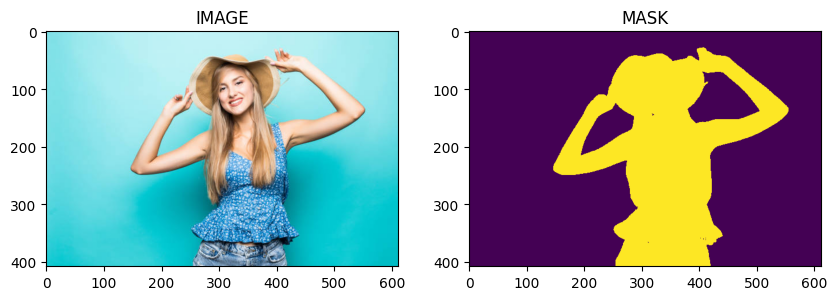

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [19]:
import albumentations as A

def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)  # Add this

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
    ], is_check_shapes=False)  # Add this

In [20]:
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h, w, c)
        mask = np.expand_dims(mask, axis=-1)                # (h, w, 1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # (h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [21]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [22]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


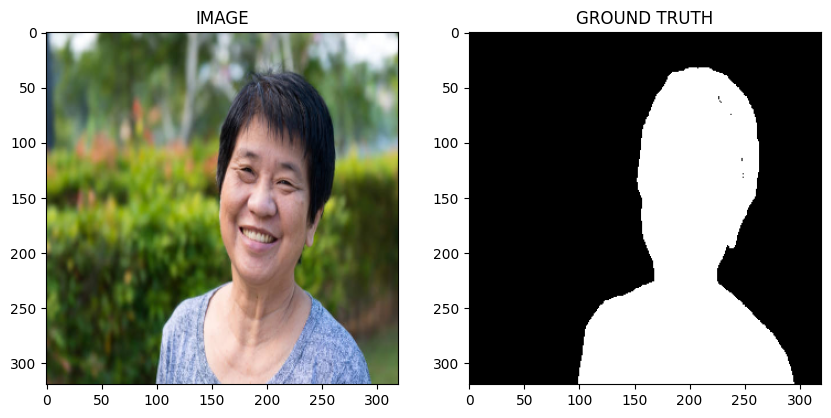

In [24]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

In [25]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [26]:
for image, mask in trainloader:
    break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


In [27]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)

        if masks is None:
            return logits

        loss1 = DiceLoss(mode='binary')(logits, masks)
        loss2 = nn.BCEWithLogitsLoss()(logits, masks)
        return logits, loss1 + loss2

In [29]:
model = SegmentationModel()
model.to(DEVICE);

In [30]:
from tqdm import tqdm

def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)

In [32]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=LR)

best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("SAVED-MODEL")
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1} Train loss : {train_loss} Valid loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


SAVED-MODEL
Epoch : 1 Train loss : 0.8267974555492401 Valid loss : 1.2812791019678116


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


SAVED-MODEL
Epoch : 2 Train loss : 0.3968442658583323 Valid loss : 0.4554944448173046


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


SAVED-MODEL
Epoch : 3 Train loss : 0.31398756404717765 Valid loss : 0.3315831944346428


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


SAVED-MODEL
Epoch : 4 Train loss : 0.24265098373095195 Valid loss : 0.24900688603520393


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


SAVED-MODEL
Epoch : 5 Train loss : 0.2521141161521276 Valid loss : 0.2301946058869362


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Epoch : 6 Train loss : 0.20126092731952666 Valid loss : 0.2360059693455696


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch : 7 Train loss : 0.20193462421496708 Valid loss : 0.26978684216737747


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Epoch : 8 Train loss : 0.24942905008792876 Valid loss : 0.254637885838747


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


SAVED-MODEL
Epoch : 9 Train loss : 0.19234725534915925 Valid loss : 0.19813713058829308


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch : 10 Train loss : 0.1573725054661433 Valid loss : 0.20960352197289467


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch : 11 Train loss : 0.18009382237990698 Valid loss : 0.20789489150047302


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Epoch : 12 Train loss : 0.1795260672767957 Valid loss : 0.22239623963832855


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Epoch : 13 Train loss : 0.15826663722594578 Valid loss : 0.2041574213653803


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


SAVED-MODEL
Epoch : 14 Train loss : 0.1382719933986664 Valid loss : 0.1939733698964119


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch : 15 Train loss : 0.13345020761092505 Valid loss : 0.19617674872279167


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 16 Train loss : 0.14397059430678685 Valid loss : 0.2622195854783058


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch : 17 Train loss : 0.15335086087385813 Valid loss : 0.2229536846280098


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch : 18 Train loss : 0.14814821034669876 Valid loss : 0.2517867907881737


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Epoch : 19 Train loss : 0.12773280888795852 Valid loss : 0.24511638283729553


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch : 20 Train loss : 0.1279036154349645 Valid loss : 0.23167063295841217


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch : 21 Train loss : 0.14685400476058325 Valid loss : 0.22344766929745674


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch : 22 Train loss : 0.12237106561660767 Valid loss : 0.20117785036563873


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


SAVED-MODEL
Epoch : 23 Train loss : 0.10130333403746287 Valid loss : 0.17818864434957504


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Epoch : 24 Train loss : 0.10722697128852209 Valid loss : 0.20042237266898155


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]

Epoch : 25 Train loss : 0.09932979196310043 Valid loss : 0.20519499853253365


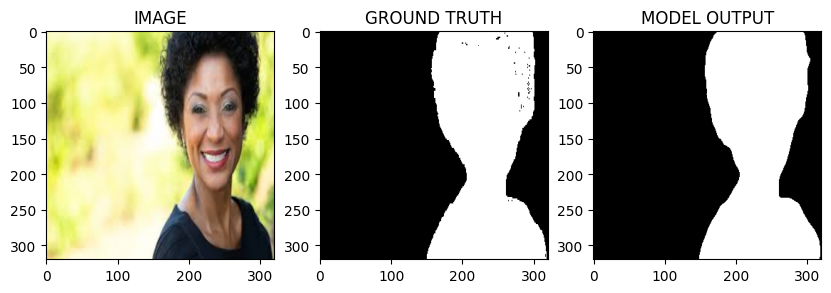

In [34]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [48]:
from google.colab import files

files.download('/content/best_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>